In [ ]:
###
    # This code is to test the robustness of the emergent relationship,
    # using different sets of model ensembles.
    # Refer to Chen et al.(2022).
    # Output: Figure S9.
###

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

In [7]:
def read_data_file(file_path):
    with open(file_path) as file:
        data_lines = file.readlines()
    data = [float(line.strip()) for line in data_lines]
    return data

def student_t_threshold(alpha, n):
    # alpha is the significance level, n is the sample size
    return stats.t.isf(q=alpha, df=n-2) / np.sqrt(n - 2)

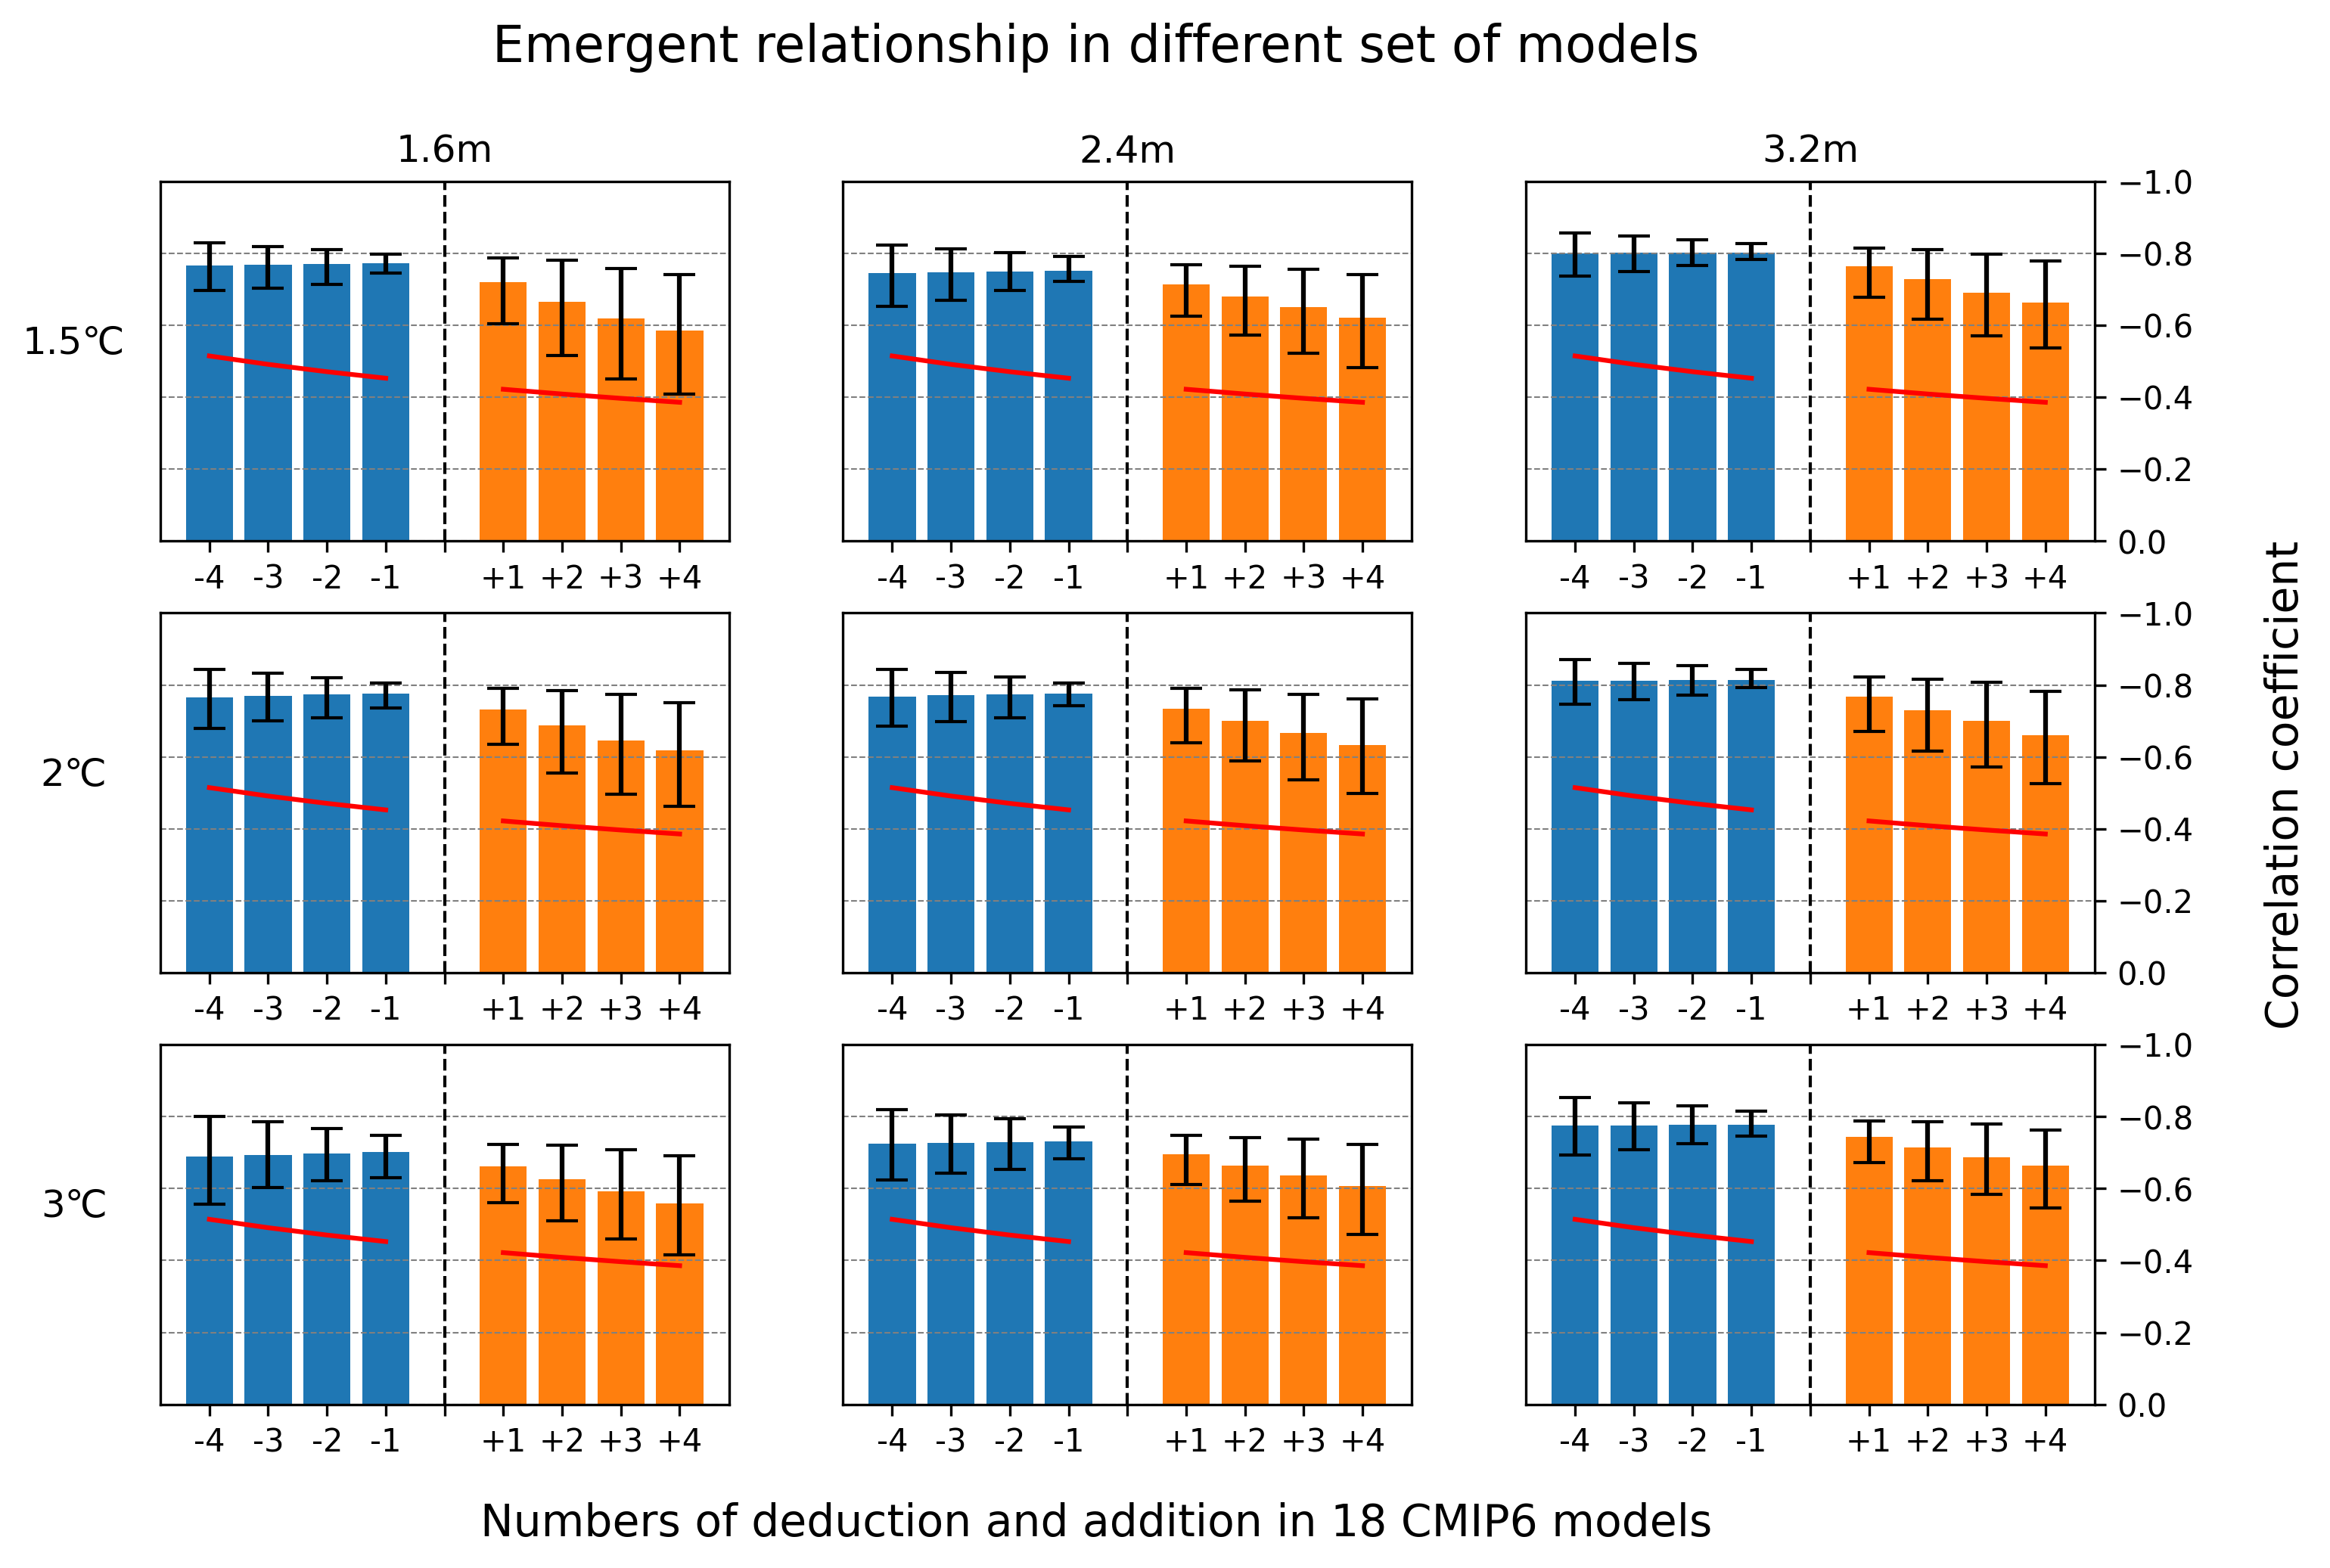

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(11, 7),dpi=300)
model = ["CESM2","CESM2-FV2","CESM2-WACCM","CNRM-CM6-1-HR","CNRM-CM6-1","CNRM-ESM2-1","E3SM-1-1","FGOALS-f3-L","FGOALS-g3","GFDL-CM4","GFDL-ESM4","MIROC6","MIROC-ES2L","MPI-ESM1-2-HR","MPI-ESM1-2-LR","NorESM2-LM","NorESM2-MM","TaiESM1"]
num_models = len(model)
Depth = ['160cm','240cm','320cm']
Degree = ['1.5','2','3']
alpha = 0.05  # Significance level

for i in range(len(Depth)):
    for j in range(len(Degree)):
        depth=Depth[i]
        degree=Degree[j]
        Ts_dt = read_data_file( "../Data/Ts_seasonal_sensitivity/Ts"+depth+"_Ts02_all_station_avg_obs_18model.txt")
        pfarea_dt = pd.read_csv("../Data/Permafrost_sensitivity/" + depth + "_permafrost_sensitivity_under_climate_change_ssp585.csv").set_index('model').loc[model]
        df = pd.DataFrame({'Model': model, 'Ts': Ts_dt[:-2], 'Climate Sensitivity': pfarea_dt[degree]})

        # Store correlation values for each iteration
        correlation_values1 = []
        thresholds1 = []
        # Store the average correlation and standard deviation for different model counts
        average_correlations1 = []
        average_correlations2 = []
        thresholds2 = []
        error_bars_5_1 = []
        error_bars_95_1 = []

        # Generate all possible combinations of model counts from 1 to num_models
        for num_to_remove in range(4, 0, -1):
            # Generate all possible combinations of models for the current count
            all_combinations = combinations(df.index, num_to_remove)
            correlations_for_num_models = []
            
            # Iterate through each combination
            for combo in all_combinations:
                # Remove models in the current combination
                df_removed = df.drop(list(combo))
                # Calculate the correlation of the remaining models
                correlation = df_removed['Ts'].corr(df_removed['Climate Sensitivity'])
                # Add the correlation value to the list
                correlations_for_num_models.append(correlation)
            
            # Calculate the 10th and 90th percentiles of correlation values
            percentile_5 = np.percentile(correlations_for_num_models, 10)
            percentile_95 = np.percentile(correlations_for_num_models, 90)
            
            # Calculate error bars
            lower_error = np.mean(correlations_for_num_models) - percentile_5
            upper_error = percentile_95 - np.mean(correlations_for_num_models)
            error_bars_5_1.append(lower_error)
            error_bars_95_1.append(upper_error)
            
            # Store all correlation values for this model count
            correlation_values1.append(correlations_for_num_models)
            # Calculate the average correlation for this model count
            avg_corr = np.mean(correlations_for_num_models)
            average_correlations1.append(avg_corr)

            # Calculate the significance test threshold for each count of removed models
            n = len(df_removed)
            threshold1 = student_t_threshold(alpha, n)
            thresholds1.append(-threshold1)

        # Store correlation values for each outlier count (1 to 4)
        correlation_values = []
        thresholds = []
        error_bars_5 = []
        error_bars_95 = []
        
        # Loop over each outlier count (1 to 4)
        for num_outliers in range(1, 5):
            # List to store correlation values for each iteration
            correlations_for_num_outliers = []
            
            # Perform 1000 iterations
            num_iterations = 1000
            for _ in range(num_iterations):
                
                # Generate random data for num_outliers
                random_data = pd.DataFrame({'Ts': np.random.uniform(low=df['Ts'].min(), high=df['Ts'].max(), size=num_outliers),
                                            'Climate Sensitivity': np.random.uniform(low=df['Climate Sensitivity'].min(), high=df['Climate Sensitivity'].max(), size=num_outliers)})
                
                # Add random data to DataFrame
                
                df_with_random_data = pd.concat([df, random_data], ignore_index=True)
                # Calculate correlation
                correlation = df_with_random_data['Ts'].corr(df_with_random_data['Climate Sensitivity'])
                
                # Add the correlation to the list
                correlations_for_num_outliers.append(correlation)

            # Calculate the 10th and 90th percentiles of correlation values
            percentile_5 = np.percentile(correlations_for_num_outliers, 10)
            percentile_95 = np.percentile(correlations_for_num_outliers, 90)
            
            # Calculate error bars
            lower_error = np.mean(correlations_for_num_outliers) - percentile_5
            upper_error = percentile_95 - np.mean(correlations_for_num_outliers)
            error_bars_5.append(lower_error)
            error_bars_95.append(upper_error)
            
            # Store all correlation values for this outlier count
            correlation_values.append(correlations_for_num_outliers)
            
            # Perform t-test to calculate threshold
            n = len(df_with_random_data)
            threshold = student_t_threshold(alpha, n)
            thresholds.append(-threshold)

        average_correlations = [np.mean(correlations) for correlations in correlation_values]
        # Combine data from both plots into one array
        average_correlations2 = average_correlations1 + average_correlations
        thresholds2 = thresholds1 + thresholds
        error_bars_5_2 = error_bars_5_1 + error_bars_5
        error_bars_95_2 = error_bars_95_1 + error_bars_95
        
        # Draw bar charts
        axs[j,i].bar(range(-4, 0), average_correlations2[:4], capsize=5)
        axs[j,i].bar(range(1, 5), average_correlations2[4:], capsize=5)
        
        # Plot bar charts with error bars
        axs[j,i].errorbar(range(-4, 0), average_correlations2[:4],
                           yerr=[error_bars_5_2[:4], error_bars_95_2[:4]],
                           color='black', fmt='none',
                           capsize=5)
        axs[j,i].errorbar(range(1, 5), average_correlations2[4:],
                           yerr=[error_bars_5_2[4:], error_bars_95_2[4:]],
                           color='black', fmt='none',
                           capsize=5)
        
        axs[j,i].plot(range(-4, 0), thresholds2[:4], linestyle='-', color='red')
        axs[j,i].plot(range(1, 5), thresholds2[4:], linestyle='-', color='red')
        axs[j,i].axvline(x=0, color='black', linestyle='--', linewidth=1)  # Add vertical line at position 0
        axs[j,i].set_xticks(range(-4, 5))

        ticks = [-4, -3, -2, -1, '', 1, 2, 3, 4]
        tick_labels = []
        for tick in ticks:
            if isinstance(tick, int) and tick > 0:
                tick_labels.append(f'+{tick}')
            else:
                tick_labels.append(str(tick))
        axs[j,i].set_xticklabels(tick_labels)
        axs[j,i].set_ylim(0, -1)
        axs[j,i].grid(axis='y', linestyle='--', color='gray', linewidth=0.5)

for i, title in enumerate(['1.6m', '2.4m', '3.2m']):
    axs[0, i].set_title(title, fontsize=12)

y_labels = ['1.5℃', '2℃', '3℃']
for i, ylabel in enumerate(y_labels):
    axs[i, 0].set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=-4)

# Set y-axis tick labels on the right for each subplot
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if j == 2: 
            ax.yaxis.tick_right()
            ax.yaxis.set_tick_params(labelright=True)
        else:  
            ax.yaxis.set_tick_params(labelright=True, colors='white') 

fig.suptitle('Emergent relationship in different set of models', fontsize=16)
fig.text(0.5, 0.027, 'Numbers of deduction and addition in 18 CMIP6 models', ha='center', fontsize=14)
fig.text(0.968, 0.5, 'Correlation coefficient', va='center', rotation='vertical', fontsize=14)
plt.show()

In [9]:
fig.savefig("../Figures/FigureS9.png", bbox_inches='tight',dpi=300)